<a href="https://colab.research.google.com/github/jari-el13/dsc-capstone-project-v2-onl01-dtsc-ft-041320/blob/master/CTGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns


import statsmodels.api as sm
import statsmodels.stats as sts
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV


pd.set_option('display.max_columns', None)  # Unlimited columns
pd.options.mode.use_inf_as_na = True

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pip install sdmetrics


In [3]:

from sdmetrics import evaluate


# Data Cleaning

In [4]:
train_data = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')
test_data = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv')
train_labels = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')

train = train_data.merge(train_labels, on='id', how='inner')
test_data_copy = test_data.copy()

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [7]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [8]:

train_labels['status_group'].value_counts(normalize = True)


functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [9]:
train['installer'].value_counts()
# Five main installers are DWE, Government, RWE, Commu, DANIDA

DWE                 17402
Government           1825
RWE                  1206
Commu                1060
DANIDA               1050
                    ...  
Natio                   1
DMDD/SOLIDER            1
DSP                     1
FARM-AFRICA             1
Water user Group        1
Name: installer, Length: 2145, dtype: int64

In [6]:
# installer put into different categories
def clean_installer(train):
     if train['installer']=='DWE':
         return 'dwe'
     elif train['installer']=='Government':
         return 'government'
     elif train['installer']=='RWE':
         return 'rwe'
     elif train['installer']=='Commu':
         return 'commu'
     elif train['installer']=='DANIDA':
         return 'danida'    
     else:
         return 'other'
    
train['installer']= train.apply(lambda row: clean_installer(row), axis=1)
test_data_copy['installer']= test_data_copy.apply(lambda row: clean_installer(row), axis=1)

In [7]:
train['installer'].value_counts()

other         36857
dwe           17402
government     1825
rwe            1206
commu          1060
danida         1050
Name: installer, dtype: int64

In [8]:


train['funder'].value_counts()

Government Of Tanzania       9084
Danida                       3114
Hesawa                       2202
Rwssp                        1374
World Bank                   1349
                             ... 
Hotels And Lodge Tanzania       1
Kizenga                         1
Overnment                       1
Ccpk                            1
Kkkt Mareu                      1
Name: funder, Length: 1897, dtype: int64

In [9]:
def funder_cleaning(train):
  if train['funder']=='Government Of Tanzania':
    return 'government'
  elif train['funder']=='Danida':
    return 'danida'
  elif train['funder']=='Hesawa':
    return 'hesawa'
  elif train['funder']=='Rwssp':
    return 'rwssp'
  elif train['funder']=='World Bank':
    return 'world_bank'    
  else:
    return 'other'
    
train['funder']= train.apply(lambda row: funder_cleaning(row), axis=1)
test_data_copy['funder']= test_data_copy.apply(lambda row: funder_cleaning(row), axis=1)

In [10]:

train['funder'].value_counts()

other         42277
government     9084
danida         3114
hesawa         2202
rwssp          1374
world_bank     1349
Name: funder, dtype: int64

In [11]:
train['scheme_management'].value_counts()


VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [12]:

def scheme_wrangler(row):
     '''Keep top 5 values and set the rest to 'other'. '''
     if row['scheme_management']=='VWC':
         return 'vwc'
     elif row['scheme_management']=='WUG':
         return 'wug'
     elif row['scheme_management']=='Water authority':
         return 'wtr_auth'
     elif row['scheme_management']=='WUA':
         return 'wua'
     elif row['scheme_management']=='Water Board':
         return 'wtr_brd'
     else:
         return 'other'

train['scheme_management'] = train.apply(lambda row: scheme_wrangler(row), axis=1)
test_data_copy['scheme_management'] = test_data_copy.apply(lambda row: scheme_wrangler(row), axis=1)

In [13]:
train.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                       0
gps_height                   0
installer                    0
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management            0
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [14]:

# Will also drop scheme_name feature because it is missing 47.4 of its values in the test dataset
train.drop(['scheme_name'], axis=1, inplace=True)
test_data_copy.drop(['scheme_name'], axis=1, inplace=True)

In [15]:
# Since public_meeting gives us true of false to rather the well if for public meeting and the
# majority of the vales are true we will fill the 5.9 percent of the missing values with true.
train['public_meeting'] = train['public_meeting'].fillna('True')
test_data_copy['public_meeting'] = test_data_copy['public_meeting'].fillna('True')

In [16]:

# The permit feature is missin a little over 5% of its values so they will be filled with a string
train['permit'] = train['permit'].fillna('Unsure')
test_data_copy['permit'] = test_data_copy['permit'].fillna('Unsure')

In [17]:

# We will drop train waterpoint_type because it is very close to waterpoint_type_group and redundency isn't good
train.drop(['waterpoint_type'], axis=1, inplace=True)
test_data_copy.drop(['waterpoint_type'], axis=1, inplace=True)

In [18]:



# Dropping the feature recorded_by because it has the same value which is not useful
train.drop(['recorded_by'], axis=1, inplace=True)
test_data_copy.drop(['recorded_by'], axis=1, inplace=True)

In [19]:


# Source and source type are very similar to the point where it seems some
# of the value groups have been grouped together so we will drop souce 

train.drop(['source'], axis=1, inplace=True)
test_data_copy.drop(['source'],axis=1, inplace=True)

In [20]:
train.drop(['quality_group'], axis=1, inplace=True)
test_data_copy.drop(['quality_group'], axis=1, inplace=True)  

In [21]:
train.drop(['payment'], axis=1, inplace=True)
test_data_copy.drop(['payment'], axis=1, inplace=True)

In [22]:
# The extraction features are very similar and even seem to be a little mergered so we will drop two of them
train.drop(['extraction_type_group'], axis=1, inplace=True)
test_data_copy.drop(['extraction_type_group'], axis=1, inplace=True)

train.drop(['extraction_type'], axis=1, inplace=True)
test_data_copy.drop(['extraction_type'], axis=1, inplace=True)

In [23]:

# We will drop management because management_group is the categorized version of the data
train.drop(['management'], axis=1, inplace=True)
test_data_copy.drop(['management'], axis=1, inplace=True)

In [24]:
def cat_construction(x):
     if x['construction_year'] >= int(1960) and x['construction_year'] < int(1970):
         return '60s'
     elif x['construction_year'] >= int(1970) and x['construction_year'] < int(1980):
         return '70s'
     elif x['construction_year'] >= int(1980) and x['construction_year'] < int(1990):
         return '80s'
     elif x['construction_year'] >= int(1990) and x['construction_year'] < int(2000):
         return '90s'
     elif x['construction_year'] >= int(2000) and x['construction_year'] < int(2010):
         return '00s'
     elif x['construction_year'] >= int(2010):
         return '10s'
     else:
         return 'unknown'
    
train['construction_year'] = train.apply(lambda x: cat_construction(x), axis=1)
test_data_copy['construction_year'] = test_data_copy.apply(lambda x: cat_construction(x), axis=1)

In [25]:
train.drop(['subvillage'], axis=1, inplace=True)
test_data_copy.drop(['subvillage'], axis=1, inplace=True)

In [26]:
train.drop(['date_recorded'], axis=1, inplace=True)
test_data_copy.drop(['date_recorded'], axis=1, inplace=True)

In [27]:
train[("longitude")] = train[("longitude")].astype(int)


In [28]:
train[("latitude")] = train[('latitude')].astype(int)

In [29]:
train[("amount_tsh")] = train[("amount_tsh")].astype(int)

In [30]:
train.head(3)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,water_quality,quantity,quantity_group,source_type,source_class,waterpoint_type_group,status_group
0,69572,6000,other,1390,other,34,-9,none,0,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,109,True,vwc,False,90s,gravity,user-group,annually,soft,enough,enough,spring,groundwater,communal standpipe,functional
1,8776,0,other,1399,other,34,-2,Zahanati,0,Lake Victoria,Mara,20,2,Serengeti,Natta,280,True,other,True,10s,gravity,user-group,never pay,soft,insufficient,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25,other,686,other,37,-3,Kwa Mahundi,0,Pangani,Manyara,21,4,Simanjiro,Ngorika,250,True,vwc,True,00s,gravity,user-group,per bucket,soft,enough,enough,dam,surface,communal standpipe,functional


In [31]:
train.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year',
       'extraction_type_class', 'management_group', 'payment_type',
       'water_quality', 'quantity', 'quantity_group', 'source_type',
       'source_class', 'waterpoint_type_group', 'status_group'],
      dtype='object')

# CTGAN Model

In [ ]:
pip install sdv

In [ ]:
pip install sdv[ctgan]

In [34]:
import sdv

In [35]:
from sdv.tabular import CTGAN

In [36]:
model = CTGAN(epochs=1000)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [37]:
model.fit(train.sample(10000))

In [38]:

synth_df = model.sample(56000)

In [39]:
synth_df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,water_quality,quantity,quantity_group,source_type,source_class,waterpoint_type_group,status_group
0,62916,23,other,83,danida,35,-10,Shuleni,0,Ruvuma / Southern Coast,Ruvuma,10,2,Namtumbo,Mlambo-Itobo,398,True,wug,False,90s,handpump,user-group,on failure,soft,seasonal,seasonal,shallow well,groundwater,hand pump,functional
1,38276,35,other,883,dwe,37,-2,Milondombo,0,Pangani,Kilimanjaro,1,6,Pangani,Kikatiti,55,True,vwc,True,90s,gravity,user-group,per bucket,soft,insufficient,insufficient,spring,surface,communal standpipe,functional
2,1949,-13,other,1435,dwe,35,-2,Sekondari,0,Rufiji,Arusha,4,1,Arusha Rural,Oldonyosambu,72,True,vwc,True,00s,gravity,user-group,unknown,soft,enough,enough,spring,groundwater,communal standpipe,functional
3,66539,3,government,-1,government,30,0,Kwanyama,0,Lake Victoria,Kagera,15,0,Karagwe,Railway,0,True,other,True,unknown,gravity,commercial,per bucket,soft,enough,enough,spring,groundwater,communal standpipe,functional needs repair
4,5321,6,other,-10,dwe,35,-3,Kwa Njoka,0,Internal,Dodoma,5,0,Rufiji,Bonde la Songwe,-3,True,vwc,False,unknown,handpump,user-group,never pay,soft,enough,enough,shallow well,groundwater,hand pump,non functional


In [40]:
synth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     56000 non-null  int64 
 1   amount_tsh             56000 non-null  int64 
 2   funder                 56000 non-null  object
 3   gps_height             56000 non-null  int64 
 4   installer              56000 non-null  object
 5   longitude              56000 non-null  int64 
 6   latitude               56000 non-null  int64 
 7   wpt_name               56000 non-null  object
 8   num_private            56000 non-null  int64 
 9   basin                  56000 non-null  object
 10  region                 56000 non-null  object
 11  region_code            56000 non-null  int64 
 12  district_code          56000 non-null  int64 
 13  lga                    56000 non-null  object
 14  ward                   56000 non-null  object
 15  population         

In [41]:
synth_df.to_csv('pump_it_synt_df.csv', index=False)


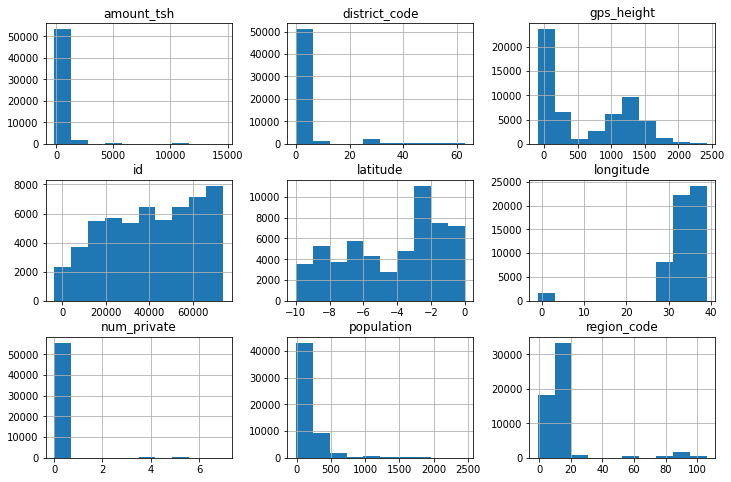

In [81]:
synth_df.hist(figsize = (12,8));


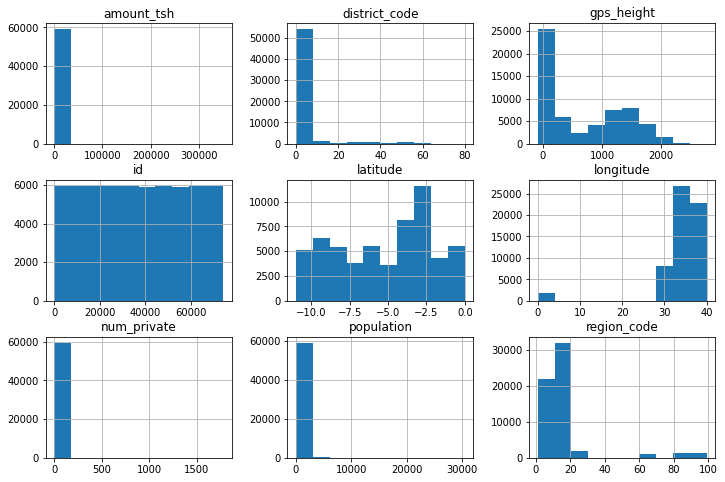

In [80]:
train.hist(figsize=(12,8));

<Figure size 800x640 with 0 Axes>

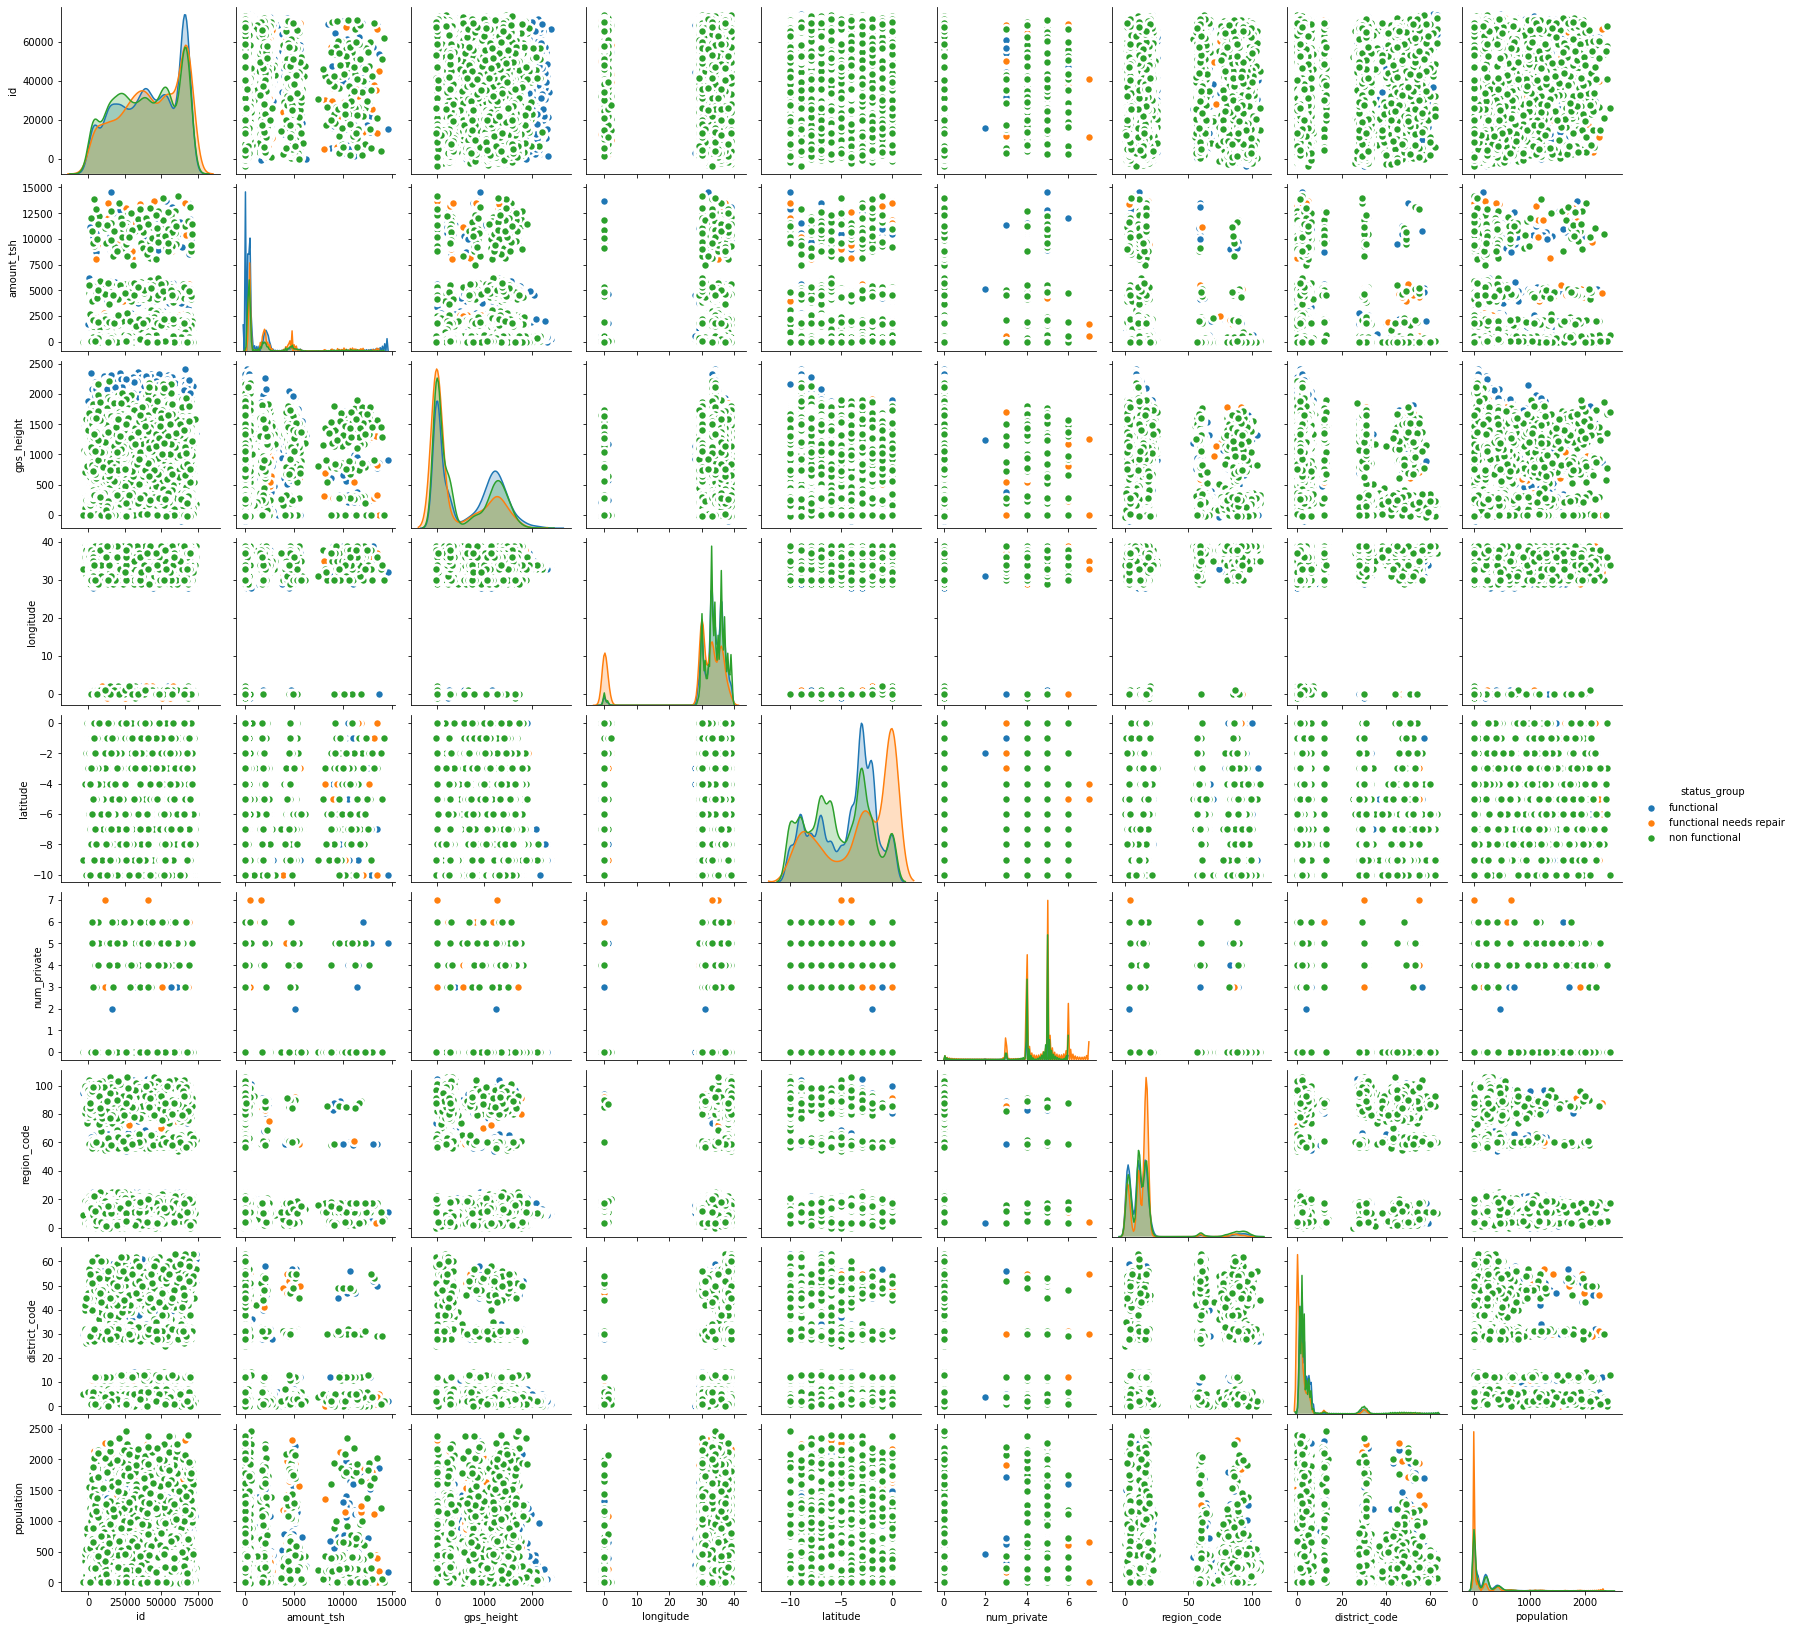

In [63]:
# Synth Data
# Plot
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(synth_df, kind="scatter", hue="status_group", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()


In [65]:
synth_df['status_group'].value_counts(normalize = True)


functional                 0.562393
non functional             0.374661
functional needs repair    0.062946
Name: status_group, dtype: float64

In [82]:
train_labels['status_group'].value_counts(normalize = True)


functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

<Figure size 800x640 with 0 Axes>

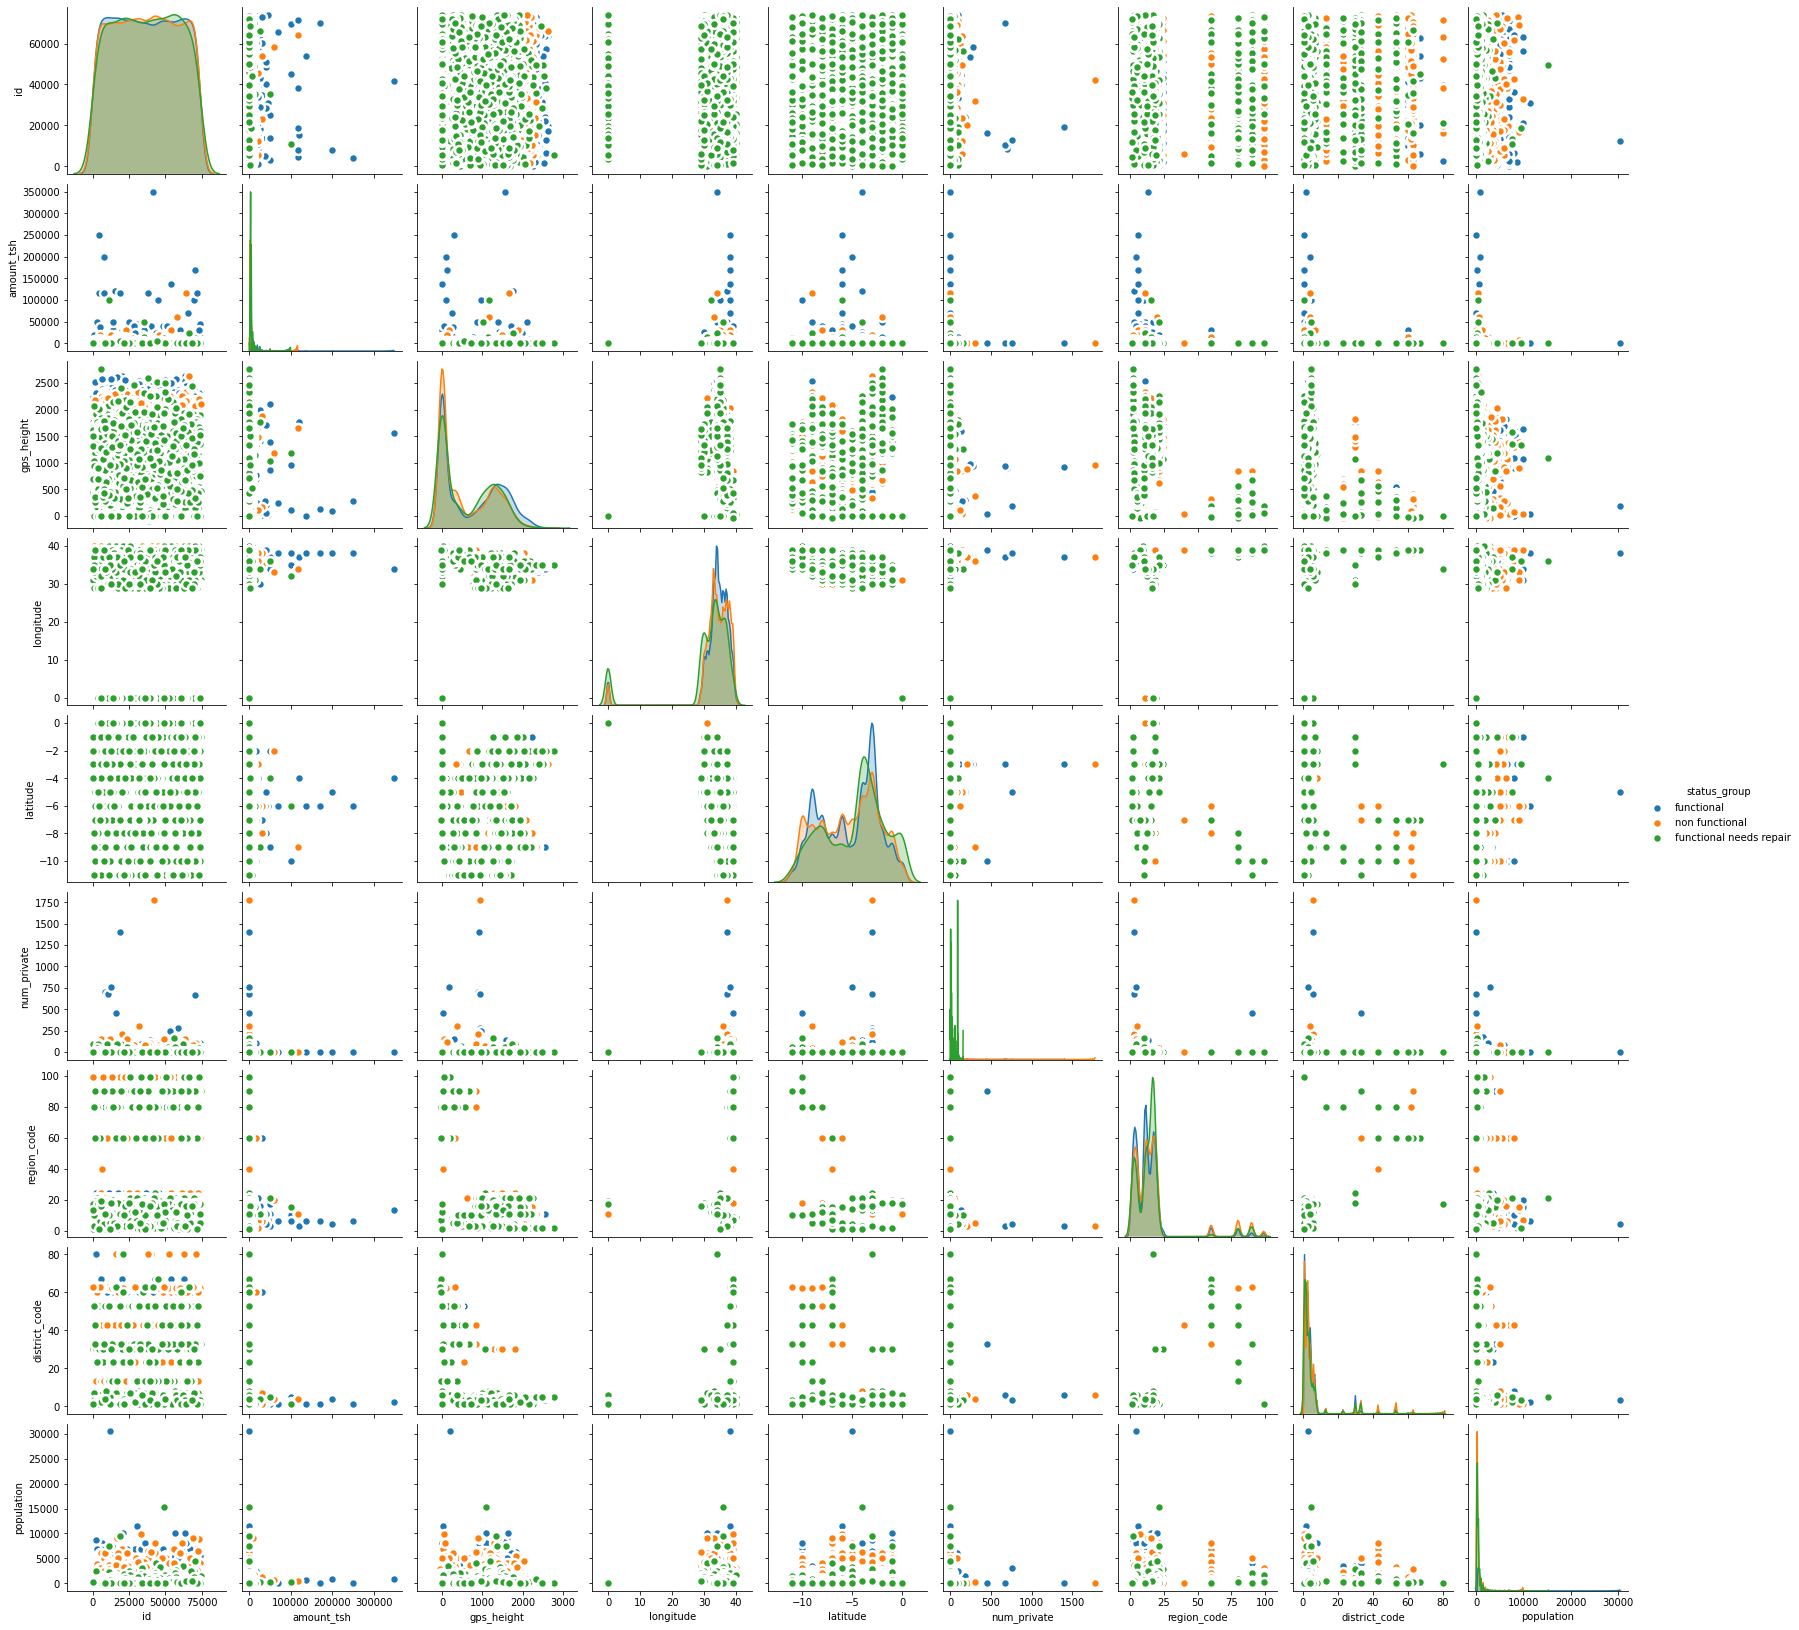

In [64]:
# Real Data
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(train, kind="scatter", hue="status_group", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

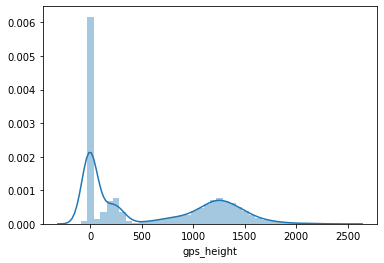

In [76]:
sns.distplot(synth_df["gps_height"])

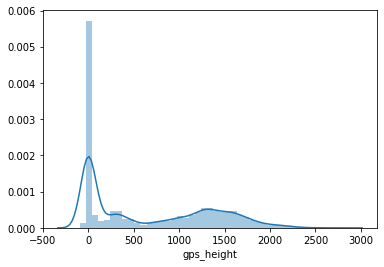

In [78]:
sns.distplot(train['gps_height'])


In [90]:
synth_df_3 = synth_df

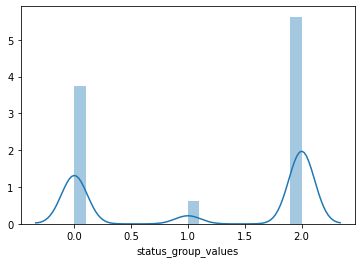

In [102]:
sns.distplot(synth_df["status_group_values"])

In [104]:
train_3 = train

In [105]:
#convert status group label into numerical data
status_group={'functional':2, 'functional needs repair':1,
                   'non functional':0}
train_3['status_group_values']=train_3.status_group.replace(status_group)

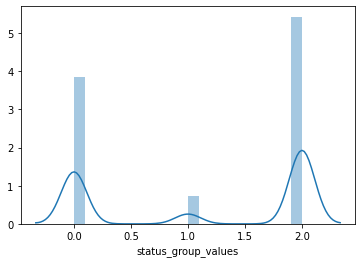

In [106]:
sns.distplot(train_3["status_group_values"])

In [96]:
synth_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     56000 non-null  int64 
 1   amount_tsh             56000 non-null  int64 
 2   funder                 56000 non-null  object
 3   gps_height             56000 non-null  int64 
 4   installer              56000 non-null  object
 5   longitude              56000 non-null  int64 
 6   latitude               56000 non-null  int64 
 7   wpt_name               56000 non-null  object
 8   num_private            56000 non-null  int64 
 9   basin                  56000 non-null  object
 10  region                 56000 non-null  object
 11  region_code            56000 non-null  int64 
 12  district_code          56000 non-null  int64 
 13  lga                    56000 non-null  object
 14  ward                   56000 non-null  object
 15  population         

In [91]:
status_group={'functional':2, 'functional needs repair':1,
                   'non functional':0}
synth_df_3['status_group_values']=synth_df_3.status_group.replace(status_group)

In [92]:
# Function that will create distplot and scatter plots
def feat_plots(feature,target,df):
   

    print(feature)
    
    #Histogram using sns distplot
    plt.title("{} histogram".format(feature))
    sns.distplot(df[feature])
    plt.show()
    
    #Scatter Plot using sns lmplot
    sns.lmplot(x=feature, y=target, data=df, line_kws={'color': 'red'})
    plt.title("{} vs {}".format(target, feature))
    plt.show()
    
    pass

In [99]:
feat_names = ['id', 'amount_tsh', 'gps_height',
                 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population']

id


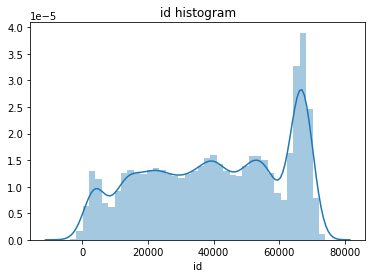

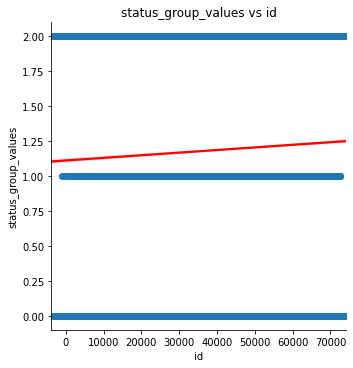

amount_tsh


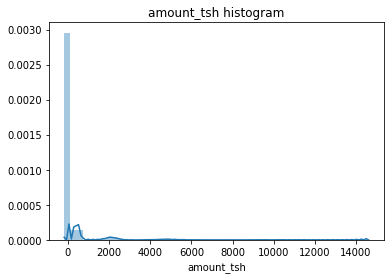

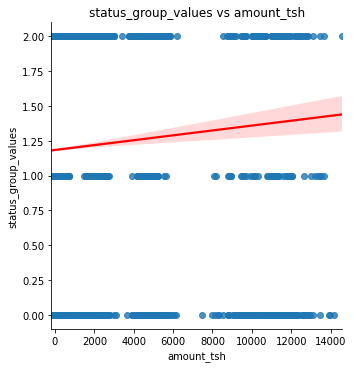

gps_height


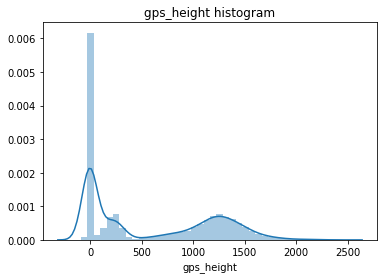

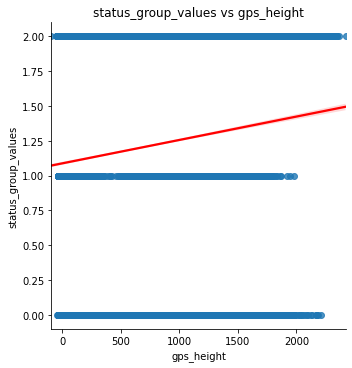

longitude


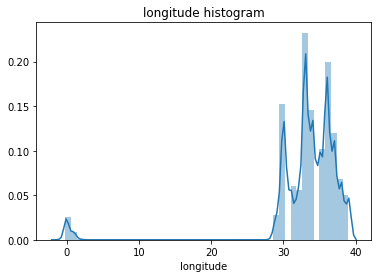

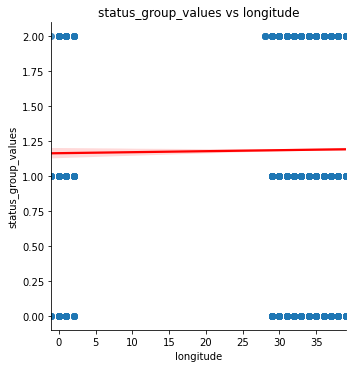

latitude


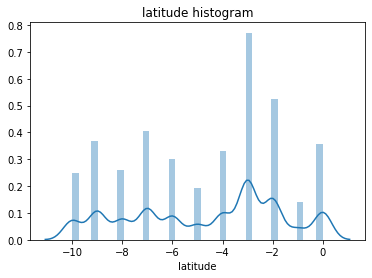

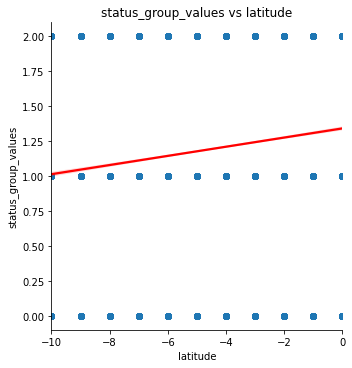

num_private


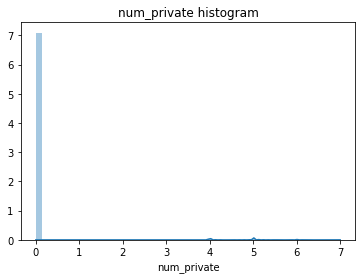

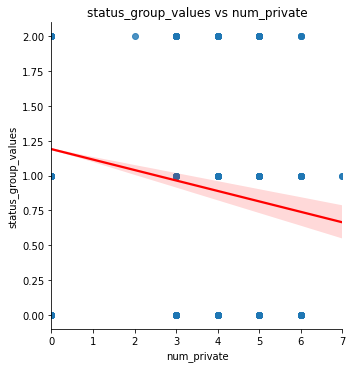

region_code


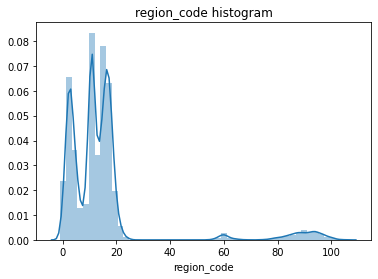

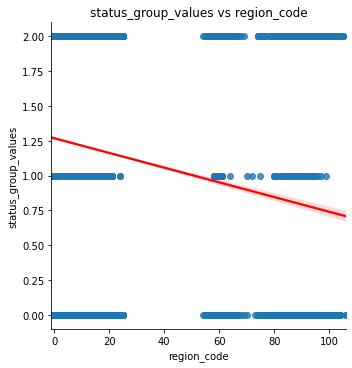

district_code


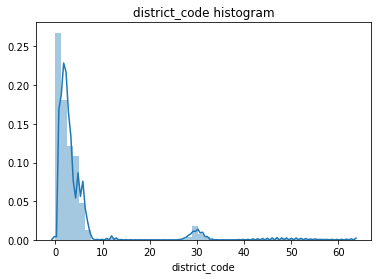

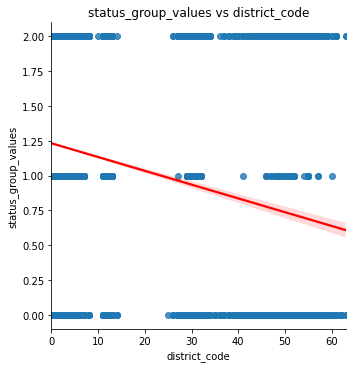

population


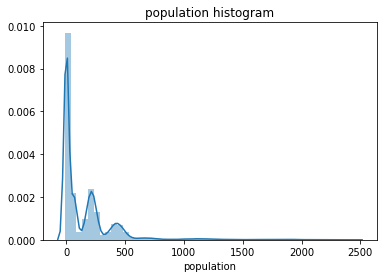

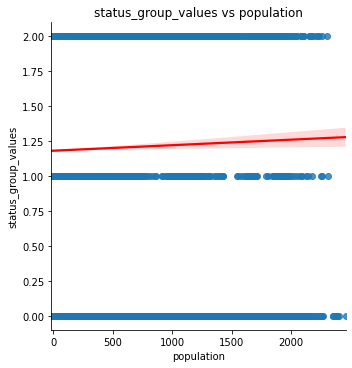

In [100]:
for feature in feat_names:
    feat_plots(feature, 'status_group_values', synth_df_3)

#### Evaluate 


In [44]:
from sdv.evaluation import evaluate

In [ ]:
eval = evaluate(synth_df, train)

# Random Forest for synthetic train

In [47]:
synth_df_2 = synth_df

In [48]:
synth_df_num_2 = synth_df_2.select_dtypes(include = np.number).copy()
synth_df_num_2.head(1)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population
0,62916,23,83,35,-10,0,10,2,398


In [49]:
# Encode features with more then < 50 unique values, numberical columns to that dataframe
X_synth_df_2 = synth_df_2.loc[:, synth_df_2.nunique().sort_values() < 50]
print('X_synth_df_2:', X_synth_df_2.shape)
X_synth_df_2.head()

X_synth_df_2: (56000, 21)


,funder,installer,longitude,latitude,num_private,basin,region,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,water_quality,quantity,quantity_group,source_type,source_class,waterpoint_type_group,status_group
0,other,danida,35,-10,0,Ruvuma / Southern Coast,Ruvuma,True,wug,False,90s,handpump,user-group,on failure,soft,seasonal,seasonal,shallow well,groundwater,hand pump,functional
1,other,dwe,37,-2,0,Pangani,Kilimanjaro,True,vwc,True,90s,gravity,user-group,per bucket,soft,insufficient,insufficient,spring,surface,communal standpipe,functional
2,other,dwe,35,-2,0,Rufiji,Arusha,True,vwc,True,00s,gravity,user-group,unknown,soft,enough,enough,spring,groundwater,communal standpipe,functional
3,government,government,30,0,0,Lake Victoria,Kagera,True,other,True,unknown,gravity,commercial,per bucket,soft,enough,enough,spring,groundwater,communal standpipe,functional needs repair
4,other,dwe,35,-3,0,Internal,Dodoma,True,vwc,False,unknown,handpump,user-group,never pay,soft,enough,enough,shallow well,groundwater,hand pump,non functional


In [50]:
synth_cat_cols_train_2 = list(X_synth_df_2.select_dtypes(['object']).columns.values)

X_categorical_synth_train_2 = X_synth_df_2[synth_cat_cols_train_2].apply(lambda x: x.astype('category').cat.codes)
X_categorical_synth_train_2.head()

,funder,installer,basin,region,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,water_quality,quantity,quantity_group,source_type,source_class,waterpoint_type_group,status_group
0,3,1,7,16,1,5,0,5,1,4,3,6,3,3,5,0,3,0
1,3,2,5,6,1,1,1,5,0,4,5,6,2,2,6,1,1,0
2,3,2,6,0,1,1,1,0,0,4,6,6,1,1,6,0,1,0
3,1,3,4,4,1,0,1,6,0,0,5,6,1,1,6,0,1,1
4,3,2,0,2,1,1,0,6,1,4,2,6,1,1,5,0,3,2


In [51]:
X_synth_train_2_select = synth_df_num_2.join(X_categorical_synth_train_2)
X_synth_train_2_select.shape

(56000, 27)

In [52]:
X_synth_train_2_select.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,funder,installer,basin,region,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,water_quality,quantity,quantity_group,source_type,source_class,waterpoint_type_group,status_group
0,62916,23,83,35,-10,0,10,2,398,3,1,7,16,1,5,0,5,1,4,3,6,3,3,5,0,3,0
1,38276,35,883,37,-2,0,1,6,55,3,2,5,6,1,1,1,5,0,4,5,6,2,2,6,1,1,0
2,1949,-13,1435,35,-2,0,4,1,72,3,2,6,0,1,1,1,0,0,4,6,6,1,1,6,0,1,0
3,66539,3,-1,30,0,0,15,0,0,1,3,4,4,1,0,1,6,0,0,5,6,1,1,6,0,1,1
4,5321,6,-10,35,-3,0,5,0,-3,3,2,0,2,1,1,0,6,1,4,2,6,1,1,5,0,3,2


In [53]:
# Test data
test_data_copy_2 = test_data_copy

In [54]:
X_test_num = test_data_copy_2.select_dtypes(include = np.number).copy()


In [55]:
X_test_2_select = test_data_copy_2.loc[:, test_data_copy_2.nunique().sort_values() < 50]


In [56]:
cat = list(X_test_2_select.select_dtypes(['object']).columns.values)
X_test_cat = X_test_2_select[cat].apply(lambda x: x.astype('category').cat.codes)

X_test_sel = X_test_num.join(X_test_cat)

#### Model

In [57]:
synth_target = X_synth_train_2_select['status_group']
synth_train = X_synth_train_2_select.drop("status_group", axis=1)

In [58]:
# Decision Tree
clf = DecisionTreeClassifier()


In [59]:
synth_cv_score = cross_val_score(clf, 
                            synth_train, synth_target,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 1)
synth_cv_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished


array([0.6329887 , 0.62731023, 0.63007607])

In [ ]:
# Random Forest


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    synth_train, synth_target, test_size=0.2)

In [61]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7220535714285714

# Random Forest forest for real train

# To see results from real train data please go to the link below

[link text](https://github.com/jari-el13/dsc-mod-3-project-v2-1-onl01-dtsc-ft-041320/blob/master/student.ipynb)

Results: Random Forest 80%